<a href="https://colab.research.google.com/github/VincentK1991/BERT_summarization_1/blob/master/notebook/Primer_to_BERT_extractive_summarization_March_25_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

This notebook aims at first time users of BERT. We will use pre-trained BERT model for extractive summarization purposes. Roughly speaking, we are using pre-trained BERT as sentence embedding tool. Subsequently we use traditional ML tool, namely nearest-neighbors, k-means clustering, and dimensionality reduction to retrieve and visualize semantic clustering encoded in the text.

Now let me give a paragraph summary of BERT. BERT is a NLP encoder model developed by Google [see reference here](https://arxiv.org/abs/1810.04805). The model achieved tremenouse success in many bench-mark tests, such as translation, Q&A, and sentence classification, around 2018-2019, and is considered by many to be the-state-of-the-art performance in the field. This helps bring forth a new and exciting era for NLP. 

The innovation behind BERT's success are a combination of a few ingenious things.


1. **bi-directional encoding**

The training of BERT read in entire sequences of token as once. So information on the left side (i.e. beginning of phrase/sentence/paragraph) and on the right side provide context for each others (see below.) This is in contradistinction to directional encoder, where information on the end side of the text is not accessible to the front of the text.

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/bert-vs-openai-.jpg)


2. **Masked Language Model**

During the training, 15% of the words are masked out.The model is trained to predict the masked out words using the surrounding context (i.e. the unmasked words). See below where the word W4 is masked out, and the model is trained to retrieved the masked out word back. This kind of training is called self-supervised learning, meaning the labels are extracted directly from the dataset. In this way, the model "learns" the semantic of words by contextual information.

![alt text](https://miro.medium.com/max/1205/0*ViwaI3Vvbnd-CJSQ.png)


3. **Next Sentence Prediction**

The training of BERT model also incorporate sentence level information. The model gets a pair of sentences as input and learn to predict if the second sentence is the pair of the other sentence in the original document.

This task is done using a special token denoting the start and end of sentence. There are 3 kinds of embedding tokens used for training.

- special token embedding: [CLS] and [SEP] for start and end of sentence
-  paired sentence embedding: denoting sentence A and sentence B
- Positional embedding: denoting position in sequences.

![alt text](https://miro.medium.com/max/1614/0*m_kXt3uqZH9e7H4w.png)

We will be using the [CLS] trick in our extractive summarization later. So stay tune!

So in the end of the training, what do we get?

We get an encoder model where the weights capture the contextual information of language both in word level and sentence level. The idea is that this language model serves as a base model and specific tasks can be built on top of this.

# 2. Packages

We will be using Huggingface transformers library. The version we use is pytorch-based. This is a pretty nice and well-documented NLP models, including BERT and GPT-2.

For this pre-trained work, we won't be doing fine-tuning. So GPU is probably not necessary.

## 2.1 packages

In [ ]:
!pip install transformers # insall the huggingface library

     |████████████████████████████████| 542kB 2.0MB/s 
     |████████████████████████████████| 870kB 9.3MB/s 
     |████████████████████████████████| 3.7MB 10.1MB/s 
     |████████████████████████████████| 1.0MB 28.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=600d7b0527e6a003590671dc60948046eab42af6f7d2642bf461f3fd909991d9
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
%tensorflow_version 1.x
from keras.preprocessing.sequence import pad_sequences

from scipy.spatial.distance import pdist,squareform
from sklearn.decomposition import PCA

import torch
import transformers as ppb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.2 pre-trained Model

We will be using distilbert (which is a smaller version of BERT). It is 40% smaller in size, has 97% capability of base BERT, abd 60% faster.
The version we use is 'uncased' meaning the tokens are all lower-cases. 

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# 3. Data preprocessing

The task consists of

1. split paragraphs into sentence (if hasn't been done already).

2. tokenize the words in sentences to a list of numeric; add the special tokens for start and end.

3. truncating or padding.

4. Create attention masks that tell the BERT model which parts are padding and which are words.

## 3.1 Paragraph spliting

I take two random paragraphs from wikipedia and put them together. One is about Covid-19 coronavirus, and the other one is about Glen Campbell, American country singer.

In [ ]:
paragraph ="""The 2019–20 coronavirus pandemic is an ongoing pandemic of coronavirus disease 2019 (COVID-19), caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2).[4] The outbreak was first identified in Wuhan, Hubei, China, in December 2019, and was recognized as a pandemic by the World Health Organization (WHO) on 11 March 2020.[5] As of 25 March, more than 422,000 cases of COVID-19 have been reported in more than 190 countries and territories, resulting in more than 18,900 deaths and more than 109,000 recoveries.[2][3]
The virus is typically spread during close contact and via respiratory droplets produced when people cough or sneeze.[6][7] Respiratory droplets may be produced during breathing but it is not considered airborne.[6] It may also spread when one touches a contaminated surface and then their face.[6][7] It is most contagious when people are symptomatic, although spread may be possible before symptoms appear.[7] The time between exposure and symptom onset is typically around five days, but may range from two to fourteen days.[8][9] Common symptoms include fever, cough, and shortness of breath.[8] Complications may include pneumonia and acute respiratory distress syndrome.[10] There is no known vaccine or specific antiviral treatment.[6] Primary treatment is symptomatic and supportive therapy.[11] Recommended preventive measures include hand washing, covering the mouth when coughing, maintaining distance from other people, and monitoring and self-isolation for people who suspect they are infected.[6]
Efforts to prevent the virus spreading include travel restrictions, quarantines, curfews, event postponements and cancellations, and facility closures. These include a quarantine of Hubei, nationwide quarantines in Italy and elsewhere in Europe, nationwide lockdown in India, curfew measures elsewhere in China and South Korea,[12][13][14] various border closures or incoming passenger restrictions,[15][16] screening at airports and train stations,[17] and travel advisories regarding regions with community transmission.[18][19][20][21] Schools and universities have closed either on a nationwide or local basis in more than 124 countries, affecting more than 1.2 billion students.[22]
The pandemic has led to global socioeconomic disruption,[23] the postponement or cancellation of sporting, religious, and cultural events,[24] and widespread fears of supply shortages which have spurred panic buying.[25][26] Misinformation and conspiracy theories about the virus have spread online,[27][28] and there have been incidents of xenophobia and racism against Chinese and other East or Southeast Asian people.[29]
Glen Travis Campbell (April 22, 1936 – August 8, 2017) was an American singer, guitarist, songwriter, television host, and actor. He was best known for a series of hit songs in the 1960s and 1970s, and for hosting a music and comedy variety show called The Glen Campbell Goodtime Hour on CBS television, from January 1969 until June 1972.[1] He released 64 albums in a career that spanned five decades, selling over 45 million records worldwide, including twelve gold albums, four platinum albums, and one double-platinum album.
Born in Billstown, Arkansas, Campbell began his professional career as a studio musician in Los Angeles, spending several years playing with the group of instrumentalists later known as "The Wrecking Crew". After becoming a solo artist, he placed a total of 80 different songs on either the Billboard Country Chart, Billboard Hot 100, or Adult Contemporary Chart, of which 29 made the top 10 and of which nine reached number one on at least one of those charts. Among Campbell's hits are "Universal Soldier", his first hit from 1965, along with "Gentle on My Mind" (1967), "By the Time I Get to Phoenix" (1967), "Dreams of the Everyday Housewife" (1968), "Wichita Lineman" (1968), "Galveston" (1969), "Rhinestone Cowboy" (1975) and "Southern Nights" (1977).[2]
In 1967, Campbell won four Grammys in the country and pop categories. For "Gentle on My Mind", he received two awards in country and western; "By the Time I Get to Phoenix" did the same in pop. Three of his early hits later won Grammy Hall of Fame Awards (2000, 2004, 2008), while Campbell himself won the Grammy Lifetime Achievement Award in 2012. He owned trophies for Male Vocalist of the Year from both the Country Music Association (CMA) and the Academy of Country Music (ACM), and took the CMA's top award as 1968 Entertainer of the Year. Campbell played a supporting role in the film True Grit (1969), which earned him a Golden Globe nomination for Most Promising Newcomer. He also sang the title song, which was nominated for an Academy Award.
"""

In [ ]:
paragraph_split = sent_tokenize(paragraph) # split the paragraph

In [ ]:
len(paragraph_split)

30

## 3.2 Tokenization

Note the start token [CLS] is always denoted numerically as [101] and the end token [SEP] is always [102].

In [ ]:
input_tokens = []
for i in paragraph_split:
  input_tokens.append(tokenizer.encode(i, add_special_tokens=True))

In [ ]:
temp = []
for i in input_tokens:
  #print(len(i))
  temp.append(len(i))
np.max(temp)  # the longest sentence in our paragraph has 88 tokens. 

88

Recap, so far we are about this step.

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

## 3.3 Truncating and padding

The BERT model has input dimension of 512 in size. So if our sentence has more than 512 tokens, we have to truncate it somehow. In our case the max token length = 88, so this won't be necessary. 

Also, because the sentences have different lengths, we will pad the shorter ones with [PAD] which is numerically [0].

In [ ]:
input_ids = pad_sequences(input_tokens, maxlen=100, dtype="long", value=0, truncating="post", padding="post")

## 3.4 Attention Mask

This is a embedding layer of values [0] or [1]. The purpose is to tell the model to ignore the padding.

In [ ]:
def create_attention_mask(input_id):
  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]  # create a list of 0 and 1.
    attention_masks.append(att_mask)  # basically attention_masks is a list of list
  return attention_masks

In [ ]:
input_masks = create_attention_mask(input_ids)

After this is done, then we can turn our data to torch tensor object.

In [ ]:
input_ids = torch.tensor(input_ids)  
attention_mask = torch.tensor(input_masks)

# 4. Embedding

Notice that 768 is the hidden layer dimensions of the model. The model has 6 transformer layer blocks (the base-bert has 12 layers). The output has dimensions of 768 in size.

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 100 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)
transformer.layer.0.attention.q_lin.weight                (768, 768)

==== First Transformer ====

transformer.layer.0.attention.q_lin.bias                      (768,)
transformer.layer.0.attention.k_lin.weight                (768, 768)
transformer.layer.0.attention.k_lin.bias                      (768,)
transformer.layer.0.attention.v_lin.weight                (768, 768)
transformer.layer.0.attention.v_lin.bias                      (768,)
transformer.layer.0.attention.out_lin.weight              (768, 768)
transformer.layer.0.attention.out_lin.bias                    (768,)
transformer.layer.0.sa_layer_norm.weight                      (

In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Recall earlier that we has something to say about the [CLS] tokens used for start sentence embedding. So after you pass through the BERT model, this becomes the tensor position [0] and has hidden dimensions of 768. 

The BERT uses this token to sepresent sentence information. In other words, the semantic information of the whole sentence should be embedded in this 768 feature dimension. In fact, the BERT sentence classification only use this dimension of the tensor for subsequent classification task.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

In [ ]:
sentence_features = last_hidden_states[0][:,0,:].detach().numpy()

In [ ]:
sentence_features.shape  
# get the embedding sentence data shape = (number of sentence, BERT hidden layer)

(30, 768)

# 5. Machine Learning

We then can use the traditional machine learning tool, such as nearest-beighbors or clustering, to select relevant sentences.

## 5.1 Visualization

In [ ]:
array_similarity = squareform(pdist(sentence_features, metric='euclidean'))

We use euclidean distance to measure how close in semantic space are the sentences in our paragraph. 

Notice that we see clearly **2 clusters**. This is because our original paragraphs are about coronavirus (sentence 0-18) and about Glen Campbell (sentence 19-28)

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

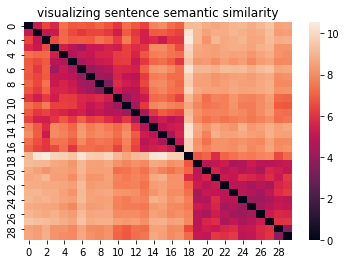

In [ ]:
sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')

In [ ]:
pca = PCA(n_components=2)
pca.fit(sentence_features)
print(np.sum(pca.explained_variance_ratio_))

0.5117953


In [ ]:
pca_sentence_features = pca.transform(sentence_features)

Text(0.5, 1.0, '2D PCA projection of embedded sentences from BERT')

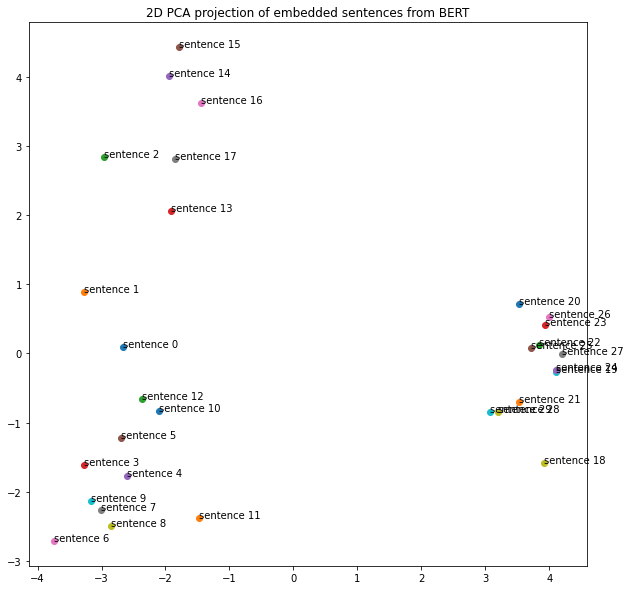

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(pca_sentence_features)):
  plt.scatter(pca_sentence_features[i,0],pca_sentence_features[i,1])
  plt.annotate('sentence '+ str(i),(pca_sentence_features[i,0],pca_sentence_features[i,1]))
plt.title('2D PCA projection of embedded sentences from BERT')

## 5.2 extracting relevant sentences

We now have many avenues to choose how to pick particular the sentences.

# Citation

- [visual notebook for first time users](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

Part of my codes and illustrations are adapted from this very easy-to-understand notebook.

- [BERT Explained](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

This blog post explains BERT very clearly. It helps me a lot when I write the introduction.

- [Fine-tuning BERT classification with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

I really like this blog post and its colab notebook. Especially the explanation about tokenization, and data formatting, which can be confusing for first-time users.

- [The original BERT paper](https://arxiv.org/pdf/1810.04805.pdf)

- [The DiltilBERT paper](https://arxiv.org/pdf/1910.01108.pdf)

- [Huggingface library](https://github.com/huggingface/transformers)